# Markdown Project: Data Cleaning

#Importar libraries



In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Dataset Stores

##Importar e visualizar ficheiro

In [2]:
file_path = '/content/Data_store.xlsx'

df_stores = pd.read_excel(file_path)
df_stores.head()

,idstore,type,selling_square_ft,district
0,1,Large,4762.0,Évora
1,2,Large,12358.0,Bragança
2,3,Large,16159.0,Lisboa
3,4,Large,17903.0,Porto
4,5,Large,16179.0,Coimbra


In [3]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   idstore            342 non-null    int64  
 1   type               342 non-null    object 
 2   selling_square_ft  311 non-null    float64
 3   district           342 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 10.8+ KB


##Data Cleaning, Transformation and Exploring

###Missing Values

In [4]:
# Verificaçao de missing values
null_counts = df_stores.isna().sum()

# Condição booleana: True se alguma variavel tiver nulos
tem_nulos = null_counts.any()

print("Nulos por coluna:")
print(null_counts)
print("\nAlguma coluna tem nulos?:", tem_nulos)

Nulos por coluna:
idstore               0
type                  0
selling_square_ft    31
district              0
dtype: int64

Alguma coluna tem nulos?: True


###Type

Variável qualitativa ordinal. Representa o tamanho de uma loja, atribuindo-lhe 3 dimensões distintas:Small, Medium e Large.

Identificado 1 valor ausente, tratado com o moda do respetivo distrito.

In [5]:
# Normalização da coluna 'type' para string, para garantir consistencia dos dados.
df_stores['type'] = (
    df_stores['type']
      .astype(str)
      .str.strip()
      .replace({'0': np.nan
      })
)

print(df_stores['type'].unique())

['Large' 'Medium' 'Small' nan]


In [6]:
#Imputar com a moda do respetivo distrito.

#Verificado valor mais frequente de type por distrito
modos = (
    df_stores.groupby('district')['type']
      .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
      .reset_index()
      .rename(columns={'type': 'type_modo'})
)

print(modos.head())

#Aplicar merge do df_stores com tabela de moda
df_stores = df_stores.merge(modos, on='district', how='left')

#Preencher type nulo com o moda do distrito
df_stores['type'] = df_stores['type'].replace("0", np.nan)
df_stores['type'] = df_stores['type'].fillna(df_stores['type_modo'])

#Fallback: se ainda restarem nulos, usar o moda global
modo_global = df_stores['type'].mode().iloc[0]
df_stores['type'] = df_stores['type'].fillna(modo_global)

#Eliminar coluna auxiliar
df_stores = df_stores.drop(columns=['type_modo'])

         district type_modo
0          Aveiro     Small
1            Beja     Small
2           Braga    Medium
3        Bragança     Small
4  Castelo Branco    Medium


In [91]:
#Verificar missing values
df_stores['selling_square_ft'].isna().sum()

np.int64(0)

###Selling_square

Variável quantitativa continua. Representa o tamanho de uma loja, em metros quadrados.

Foram identificados 31 valores ausentes, preenchidos com a mediana do par: Type e district.

In [8]:
#Imputar a mediana do par (type, district).
medianas = (
    df_stores.groupby(['type', 'district'])['selling_square_ft']
      .median()
      .reset_index()
      .rename(columns={'selling_square_ft': 'median_sqft'})
)

print(medianas.head())

#Merge do df_stores original com a tabela de medianas
df_stores = df_stores.merge(medianas, on=['type', 'district'], how='left')

# ubstituir nulos pela mediana correspondente
df_stores['selling_square_ft'] = df_stores['selling_square_ft'].fillna(df_stores['median_sqft'])

#Eliminar coluna auxiliar
df_stores = df_stores.drop(columns=['median_sqft'])


    type        district  median_sqft
0  Large          Aveiro      12231.5
1  Large            Beja      21275.0
2  Large        Bragança      13435.0
3  Large  Castelo Branco      21060.0
4  Large         Coimbra      13774.0


In [9]:
#Verificar missing values
df_stores['selling_square_ft'].isna().sum()

np.int64(0)

#Dataset Labels

##Importar e visualizar ficheiro

In [10]:
file_path = '/content/Data_labels.xlsx'
df=pd.read_excel(file_path)


In [11]:
#Merge da tabela Store com a tabela Labels

df = df.merge(
    df_stores,
    how="left",
    on="idstore"        # chave comum
)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150054 entries, 0 to 150053
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   idstore             150054 non-null  int64         
 1   sku                 150054 non-null  int64         
 2   brand               150054 non-null  object        
 3   oldpvp              150032 non-null  object        
 4   new_pvp (discount)  150026 non-null  object        
 5   labelqty            150054 non-null  int64         
 6   weight (g)          150050 non-null  object        
 7   Payment_method      150054 non-null  object        
 8   Margin (%)          150054 non-null  int64         
 9   Profit (€)          150054 non-null  float64       
 10  perc_expiring_sku   149929 non-null  float64       
 11  expiring_date       150054 non-null  object        
 12  labelling_date      150054 non-null  datetime64[ns]
 13  sell_date           80511 non

In [13]:
df.head()

,idstore,sku,brand,oldpvp,new_pvp (discount),labelqty,weight (g),Payment_method,Margin (%),Profit (€),perc_expiring_sku,expiring_date,labelling_date,sell_date,sold,type,selling_square_ft,district
0,1,1,Marca 1,4.22,2.11 (0.50),1,260,Card,16,0.3376,0.010050,03/10/2021,2021-10-01,2021-10-02,1.0,Large,4762.0,Évora
1,1,1,Marca 1,3.96,1.98 (0.50),1,260,,16,0.3168,0.005025,02/10/2021,2021-10-01,NaT,0.0,Large,4762.0,Évora
2,1,1,Marca 1,4.74,2.37 (0.50),1,260,Cash,16,0.3792,0.010050,03/10/2021,2021-10-01,2021-10-03,1.0,Large,4762.0,Évora
3,1,1,Marca 1,4.2,2.1 (0.50),1,260,Card,16,0.3360,0.010050,03/10/2021,2021-10-01,2021-10-02,1.0,Large,4762.0,Évora
4,1,1,Marca 1,4.62,2.31 (0.50),1,260,Cash,16,0.3696,0.010050,03/10/2021,2021-10-01,2021-10-03,NaN,Large,4762.0,Évora


In [14]:
#Conversão para os types ais apropriados
df = df.convert_dtypes()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150054 entries, 0 to 150053
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   idstore             150054 non-null  Int64         
 1   sku                 150054 non-null  Int64         
 2   brand               150054 non-null  string        
 3   oldpvp              150032 non-null  object        
 4   new_pvp (discount)  150026 non-null  string        
 5   labelqty            150054 non-null  Int64         
 6   weight (g)          150050 non-null  object        
 7   Payment_method      150054 non-null  string        
 8   Margin (%)          150054 non-null  Int64         
 9   Profit (€)          150054 non-null  Float64       
 10  perc_expiring_sku   149929 non-null  Float64       
 11  expiring_date       150054 non-null  string        
 12  labelling_date      150054 non-null  datetime64[ns]
 13  sell_date           80511 non

##Data Cleaning, Transformation and Exploring


###Brand

Variável qualitativa categórica, representa a classificação da marca do SKU em questão.

Temos 42 marcas distintas.

Não existem valores ausentes.

In [16]:
#Visualizar dados
df['brand'].sample(10)

,brand
58741,marca 15
128141,marca 15
13495,Marca 12
140251,marca 2
113160,marca 2
12015,Marca7
42814,Marca 2
65143,marca 2
5402,marca2
35983,marca 2


In [17]:
#Veriricar missing values
df['brand'].isnull().sum()

np.int64(0)

In [18]:
def clean_brand(brand):
    if pd.isna(brand):
        return brand
    # 1. Uppercase
    brand = brand.upper()
    # 2. Remover espaços extras
    brand = " ".join(brand.split())
    # 3. Garantir espaço entre letras e números (MARCA21 -> MARCA 21)
    brand = re.sub(r'([A-Z])(\d+)', r'\1 \2', brand)
    # 4. Capitalizar para "Marca X"
    brand = brand.title()

    return brand

In [19]:
#Validação
df['brand'] = df['brand'].apply(clean_brand)
df['brand'].unique()

print(df['brand'].nunique())
print(df['brand'].unique())

42
['Marca 1' 'Marca 2' 'Marca 3' 'Marca 4' 'Marca 5' 'Marca 6' 'Marca 7'
 'Marca 8' 'Marca 9' 'Marca 10' 'Marca 11' 'Marca 12' 'Marca 13'
 'Marca 14' 'Marca 15' 'Marca 16' 'Marca 17' 'Marca 18' 'Marca 19'
 'Marca 20' 'Marca 21' 'Marca 22' 'Marca 23' 'Marca 24' 'Marca 25'
 'Marca 26' 'Marca 27' 'Marca 28' 'Marca 29' 'Marca 30' 'Marca 31'
 'Marca 32' 'Marca 33' 'Marca 34' 'Marca 35' 'Marca 36' 'Marca 37'
 'Marca 38' 'Marca 39' 'Marca 40' 'Marca 41' 'Marca 42']


### oldpvp

Variável quantitativa contínua, representa o preço do produto, antes de ser aplicado qualquer desconto.

Identificados 22 valores ausentes.Tratamento: Preenchimento e correções após tratamento da variável newpvp (Discount). Preenchidos com base no cálculo entre estas duas.

In [20]:
df['oldpvp'].sample(10)

,oldpvp
43983,1.49
55161,1.99
92169,1.79
16290,0.69
52993,0.95
26935,"1,99"
101881,1.59
66176,0.99
123183,"1,19"
34048,"1,19"


In [21]:
#Veriricar missing values
df['oldpvp'].isnull().sum()

#tratamento efetuado apos correçao de new_pvp e discount

np.int64(22)

In [22]:
df['oldpvp'].unique()

array([4.22, 3.96, 4.74, 4.2, 4.62, 3.42, 3.62, 4.38, 5.23, 5.89, 3.78,
       4.76, 3.19, nan, '3,19', 2.65, 2.79, '2,79', 500, 46, '2,99',
       '1,39', 1.39, 2.19, '2,19', 1.19, '1,19', 1.25, '1,25', 3.99,
       '4,29', 1.99, '1,99', '0,79', 0.79, 1.29, 1.79, '1,79', '1,15',
       '2,69', 2.49, '2,49', 2.59, 4.39, '4,59', '1,49', 0.99, '0,99',
       2.99, 4.99, '4,99', 17.99, 1.49, '1,29', '2,39', 0.69, '0,69',
       0.76, 2.95, 1.59, '1,59', 1.95, '1,95', 1.89, '1,89', 3.29, '2,80',
       '3,99', '2,59', 4.15, 2.69, 1.69, '1,69', 4.59, 3.39, '3,24', 3.24,
       2.89, '2,89', 1.75, '1,75', 2.29, '2,29', 999, 0.95, '0,95', 1.54,
       '1,54', '1,09', 3.49, '3,49', 0.96, 0.98, 0.97, 1, 4.29, 1.09,
       2.75, '1,05', 3.35, 0.89, 1.15, 2.39, '0,85', 0.85, 1.55, 1.12,
       1.47, 1.22, 1.71, 1.36, 1.68, 1.05, 1.78, 1.5, 1.61, 1.33, 1.57,
       1.26, 1.43, 1.08, 2.1, 0.91, 1.4, 2.03, 0.84, 0.94, 2.5, '2,50',
       '2,09', 14.99, 0.59, '0,59', '1,33', 1.65, 3.8, 2.45, '4,89', 

In [23]:
#Normalizar separadores decimais
def normalize_decimal(x):
    if pd.isna(x):
        return x
    # garantir que é string
    x = str(x).strip()
    # trocar vírgula por ponto
    x = x.replace(",", ".")
    return x

#Aplicar a transformação decimal na coluna oldpvp
df["oldpvp"] = df["oldpvp"].apply(normalize_decimal)

#Converter para numérico
df["oldpvp"] = pd.to_numeric(df["oldpvp"], errors="coerce")

#Validar valores únicos após a limpeza
print("Valores únicos oldpvp:")
print(df["oldpvp"].unique())



Valores únicos oldpvp:
[4.220e+00 3.960e+00 4.740e+00 4.200e+00 4.620e+00 3.420e+00 3.620e+00
 4.380e+00 5.230e+00 5.890e+00 3.780e+00 4.760e+00 3.190e+00       nan
 2.650e+00 2.790e+00 5.000e+02 4.600e+01 2.990e+00 1.390e+00 2.190e+00
 1.190e+00 1.250e+00 3.990e+00 4.290e+00 1.990e+00 7.900e-01 1.290e+00
 1.790e+00 1.150e+00 2.690e+00 2.490e+00 2.590e+00 4.390e+00 4.590e+00
 1.490e+00 9.900e-01 4.990e+00 1.799e+01 2.390e+00 6.900e-01 7.600e-01
 2.950e+00 1.590e+00 1.950e+00 1.890e+00 3.290e+00 2.800e+00 4.150e+00
 1.690e+00 3.390e+00 3.240e+00 2.890e+00 1.750e+00 2.290e+00 9.990e+02
 9.500e-01 1.540e+00 1.090e+00 3.490e+00 9.600e-01 9.800e-01 9.700e-01
 1.000e+00 2.750e+00 1.050e+00 3.350e+00 8.900e-01 8.500e-01 1.550e+00
 1.120e+00 1.470e+00 1.220e+00 1.710e+00 1.360e+00 1.680e+00 1.780e+00
 1.500e+00 1.610e+00 1.330e+00 1.570e+00 1.260e+00 1.430e+00 1.080e+00
 2.100e+00 9.100e-01 1.400e+00 2.030e+00 8.400e-01 9.400e-01 2.500e+00
 2.090e+00 1.499e+01 5.900e-01 1.650e+00 3.800e+00 2.4

### new_pvp (discount)

Variavel quantitativa contínua. Representa o preço de um produto após aplicação de desconto + a percentagem de desconto aplicado.

Identificado que variável contém new_pvp + discount na mesma célula.

Tratamento: separação dos valores para colunas distintas (2 variaveis novas - newpvp + discount)

Verificados 28 valores ausentes: preenchidos através do cálculo entre Profit e Margin

In [24]:
df['new_pvp (discount)'].sample(10)

,new_pvp (discount)
23274,"1,25 (30%)"
117674,"1,18 (30%)"
138602,1.18 (0.30)
45263,"1,04 (30%)"
32784,1.6 (0.30)
120952,0.83 (0.30)
61085,"0,83 (30%)"
130573,1.18 (0.30)
2721,0.83 (0.30)
57751,1.32 (0.30)


In [25]:
#Veriricar missing values
df['new_pvp (discount)'].isnull().sum()

np.int64(28)

In [26]:
#Aplicar a transformação decimal na coluna new_pvp (discount)
df["new_pvp (discount)"] = df["new_pvp (discount)"].apply(normalize_decimal)

print("\nValores únicos new_pvp (discount):")
print(df["new_pvp (discount)"].unique()[:20])


Valores únicos new_pvp (discount):
['2.11 (0.50)' '1.98 (0.50)' '2.37 (0.50)' '2.1 (0.50)' '2.31 (0.50)'
 '1.71 (0.50)' '1.81 (0.50)' '2.19 (0.50)' <NA> '2.94 (0.50)'
 '1.89 (0.50)' '2.38 (0.50)' '1.59 (0.50)' '1.59 (50%)' '2.39 (0.25)'
 '2.39 (25%)' '2.55 (0.20)' '1.32 (0.50)' '1.32 (50%)' '1.95 (0.30)']


In [27]:
#Descobrir o nome real da coluna "newpvp (discount)" (com ou sem underscore)
def find_newpvp_discount_col(columns):
    target_norm = "newpvp(discount)"
    for c in columns:
        if c and c.strip():
            norm = c.strip().lower().replace("_", "").replace(" ", "")
            if norm == target_norm:
                return c
    # fallback: tenta por inclusão (casos mais soltos)
    for c in columns:
        norm = c.strip().lower()
        if "new" in norm and "discount" in norm:
            return c
    raise KeyError("Não encontrei a coluna de 'newpvp (discount)'. Ajusta o nome manualmente.")

col = find_newpvp_discount_col(df.columns)

#Helpers de normalização
def _clean_num_str(s: str) -> str:
    #remove símbolos e normaliza separador
    return s.replace("€", "").replace(" ", "").replace(",", ".")

def parse_price_and_discount(cell):
    """Recebe strings do tipo '2.31 (0.50)' ou '2,31 (30%)'
       Devolve: (newpvp_float, discount_float_em_fração_0_1_ou_nan)
    """
    if pd.isna(cell):
        return (np.nan, np.nan)

    s = str(cell).strip()
    m = re.match(r"^\s*([0-9][0-9\.,]*)\s*(?:\(([^)]*)\))?\s*$", s)
    if not m:
        #sem padrão esperado: tenta interpretar tudo como preço sem desconto
        price_str = _clean_num_str(s)
        price = pd.to_numeric(price_str, errors="coerce")
        return (price, np.nan)

    # preço antes dos parêntesis
    price_str = _clean_num_str(m.group(1))
    price = pd.to_numeric(price_str, errors="coerce")

    # desconto dentro dos parêntesis
    disc_raw = m.group(2)
    if disc_raw is None or str(disc_raw).strip() == "":
        return (price, np.nan)

    d = _clean_num_str(str(disc_raw))
    # remover % se existir
    if d.endswith("%"):
        d = d[:-1]

    disc_val = pd.to_numeric(d, errors="coerce")

    # Normalização para FRAÇÃO 0–1:
    # - Se NaN -> NaN
    # - Se 0 <= x <= 1 -> já é fração (ex.: 0.3 -> 0.3)
    # - Se 1 < x <= 100 -> era percentagem sem símbolo (ex.: 30 -> 0.30)
    # - Fora do intervalo -> NaN
    if pd.isna(disc_val):
        disc_frac = np.nan
    elif 0 <= disc_val <= 1:
        disc_frac = float(disc_val)
    elif 1 < disc_val <= 100:
        disc_frac = float(disc_val) / 100.0
    else:
        disc_frac = np.nan

    return (price, disc_frac)

#Criar colunas novas: newpvp (float) e discount (fração 0–1)
df[["newpvp", "discount"]] = df[col].apply(lambda x: pd.Series(parse_price_and_discount(x)))

#Confirmações rápidas
print("Amostra (original | newpvp | discount fração):")
print(df[[col, "newpvp", "discount"]].head(10))

print("\nValores únicos de discount (primeiros 20, arredondados a 4 casas):")
print(pd.unique(df["discount"].round(4)))



Amostra (original | newpvp | discount fração):
  new_pvp (discount)  newpvp  discount
0        2.11 (0.50)    2.11       0.5
1        1.98 (0.50)    1.98       0.5
2        2.37 (0.50)    2.37       0.5
3         2.1 (0.50)    2.10       0.5
4        2.31 (0.50)    2.31       0.5
5        2.31 (0.50)    2.31       0.5
6        1.71 (0.50)    1.71       0.5
7        1.81 (0.50)    1.81       0.5
8        2.31 (0.50)    2.31       0.5
9        2.19 (0.50)    2.19       0.5

Valores únicos de discount (primeiros 20, arredondados a 4 casas):
[0.5   nan 0.25 0.2  0.3  0.99 0.31 0.15 0.1  0.26 0.51 0.16 0.21 0.11
 0.4  0.35 0.17 0.03 0.28 0.18 0.48 0.05 0.36 0.02 0.23 0.01]


**Missing Values | Oldpvp -** com base em newpvp e discount

In [28]:
##Tratamento de missing values

# Garantir tipos numéricos
df["newpvp"] = pd.to_numeric(df["newpvp"], errors="coerce")
df["discount"] = pd.to_numeric(df["discount"], errors="coerce")

#Cria Nan para podermos preencher
if "oldpvp" in df.columns:
    df["oldpvp"] = pd.to_numeric(df["oldpvp"], errors="coerce")
else:
    df["oldpvp"] = np.nan

# Condições válidas para calcular oldpvp: newpvp e discount presentes, 0 >= discount < 1
valid = (
    df["newpvp"].notna()
    & df["discount"].notna()
    & (df["discount"] >= 0)
    & (df["discount"] < 1)
)

# Calcular e preencher apenas onde oldpvp está nulo
df.loc[valid & df["oldpvp"].isna(), "oldpvp"] = df.loc[valid, "newpvp"] / (1 - df.loc[valid, "discount"])

# Confirmação final
n_nulos = df["oldpvp"].isna().sum()
total = len(df)
print(f"Nulos em oldpvp após preenchimento: {n_nulos} de {total} ({(n_nulos/total*100 if total else 0):.2f}%)")


Nulos em oldpvp após preenchimento: 0 de 150054 (0.00%)


**Missing Values | Newpvp & Discount -** com base nas variáveis Profit | Margin (newpvp) e Newpvp | Oldpvp (discount)

In [29]:
# --- Helpers simples ---
def parse_money(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace("€", "").replace(" ", "").replace(",", ".")
    try: return float(s)
    except: return np.nan

def parse_percent_to_fraction(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().replace("%", "").replace(" ", "").replace(",", ".")
    try:
        v = float(s)
    except:
        return np.nan
    # aceita fração (<=1) ou percentagem (0–100)
    return v if 0 <= v <= 1 else (v/100 if 0 < v <= 100 else np.nan)

def find_col(df, key_substr):
    # encontra coluna pelo nome aproximado (case-insensitive)
    cs = [c for c in df.columns if key_substr.lower() in c.lower()]
    if not cs:
        raise KeyError(f"Não encontrei coluna com '{key_substr}'.")
    return cs[0]

#Identificar colunas Profit e Margin (ajusta se os nomes forem diferentes) ---
profit_col = find_col(df, "profit")
margin_col = find_col(df, "margin")

#Preparar séries limpas
profit = df[profit_col].apply(parse_money)
margin_frac = df[margin_col].apply(parse_percent_to_fraction)  # fração 0–1

#Garantir tipos nas colunas alvo
df["newpvp"] = pd.to_numeric(df["newpvp"], errors="coerce")
df["discount"] = pd.to_numeric(df["discount"], errors="coerce")
df["oldpvp"] = pd.to_numeric(df.get("oldpvp", np.nan), errors="coerce")

# =========================

#Preencher NEWPVP em falta: newpvp = Profit / Margin

mask_newpvp = df["newpvp"].isna() & profit.notna() & margin_frac.notna() & (margin_frac > 0)
df.loc[mask_newpvp, "newpvp"] = (profit / margin_frac)[mask_newpvp]

# =========================

#Preencher DISCOUNT em falta: discount = 1 - newpvp / oldpvp

mask_disc = (
    df["discount"].isna()
    & df["newpvp"].notna()
    & df["oldpvp"].notna()
    & (df["oldpvp"] > 0)
)
df.loc[mask_disc, "discount"] = 1 - (df.loc[mask_disc, "newpvp"] / df.loc[mask_disc, "oldpvp"])

# Opcional: invalidar descontos fora do intervalo [0, 1)
df.loc[mask_disc, "discount"] = df.loc[mask_disc, "discount"].where(
    (df.loc[mask_disc, "discount"] >= 0) & (df.loc[mask_disc, "discount"] < 1),
    np.nan
)

# --- Confirmações simples ---
print("Nulos em newpvp após preenchimento:", int(df["newpvp"].isna().sum()))
print("Nulos em discount após preenchimento:", int(df["discount"].isna().sum()))


Nulos em newpvp após preenchimento: 0
Nulos em discount após preenchimento: 0


In [30]:
#Remover coluna original de new_pvp discount por ser redundante apos duas novas criadas
df = df.drop(columns=['new_pvp (discount)'])

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150054 entries, 0 to 150053
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   idstore            150054 non-null  Int64         
 1   sku                150054 non-null  Int64         
 2   brand              150054 non-null  object        
 3   oldpvp             150054 non-null  float64       
 4   labelqty           150054 non-null  Int64         
 5   weight (g)         150050 non-null  object        
 6   Payment_method     150054 non-null  string        
 7   Margin (%)         150054 non-null  Int64         
 8   Profit (€)         150054 non-null  Float64       
 9   perc_expiring_sku  149929 non-null  Float64       
 10  expiring_date      150054 non-null  string        
 11  labelling_date     150054 non-null  datetime64[ns]
 12  sell_date          80511 non-null   datetime64[ns]
 13  sold               149940 non-null  Int64   

**Outliers | Newpvp e Oldpvp**

In [32]:
#Metodo flag para limpar Outliers de newpvp e oldpvp - selecionado percentil 99
limite_sup_newpvp = 6
print(f"New PVP Limite pelo valor: {limite_sup_newpvp:.2f}")

limite_sup_oldpvp = df['oldpvp'].quantile(0.99999)
print(f"Old PVP Limite pelo percentil 99: {limite_sup_oldpvp:.2f}")

# criar flag: 1 = outlier, 0 = normal
df["flag"] = 0
df.loc[df["newpvp"] > limite_sup_newpvp, "flag"] = 1
df.loc[df["oldpvp"] > limite_sup_oldpvp, "flag"] = 1

# verificar quantos ficaram marcados
print(f"Número de outliers identificados: {df['flag'].sum()}")

New PVP Limite pelo valor: 6.00
Old PVP Limite pelo percentil 99: 272.76
Número de outliers identificados: 15


### labelqty

Variável qualitativa categórica representa a quantidade de etiquetas atribuídas ao SKU.
Existe apenas um único valor em toda a base de dados, o que significa que não tem variabilidade estatística.
O formato é categórico/numérico uniforme e, por essa razão, a variável foi considerada não relevante para análise e removida do dataset.

- **Decisão**: remover a coluna por não ter relevância para a análise.  
- **Nota**: poderia ser interessante se existissem valores distintos noutras bases de dados.

In [33]:
# Remover a coluna
df = df.drop(columns=['labelqty'])


### weight (g)
Variável quantitativa contínua representa o peso do produto.

O peso dos produtos varia entre 1g e 410g.

Contém 428 valores ausentes. Tratamento realizado pela média por SKU respetivo

In [34]:
#transformação de type object para float64
df["weight (g)"] = pd.to_numeric(df["weight (g)"], errors="coerce")

In [35]:
#Verificaçao de missing values

# Criar máscara para todos os tipos de "missing"
mask_missing = (
    df["weight (g)"].isna() |                                   # NaN ou None
    (df["weight (g)"].astype(str).str.strip() == "") |          # strings vazias ou só espaços
    (df["weight (g)"].astype(str).str.lower() == "nan")         # strings "NaN"
)

# Contar total de valores missing
total_missing = mask_missing.sum()
print(f"Total de missing (incluindo strings e NaN): {total_missing}")

Total de missing (incluindo strings e NaN): 428


In [36]:
# Tratamento de missing pela média por SKU respetivo
df["weight (g)"] = df.groupby("sku")["weight (g)"].transform(
    lambda x: x.fillna(x.mean())
)


# E se ainda existirem nulos, usar média por marca
df["weight (g)"] = df.groupby("brand")["weight (g)"].transform(
    lambda x: x.fillna(x.mean())
)

In [37]:
mask_missing = (
    df["weight (g)"].isna() |                                   # NaN ou None
    (df["weight (g)"].astype(str).str.strip() == "") |          # strings vazias ou só espaços
    (df["weight (g)"].astype(str).str.lower() == "nan")         # strings "NaN"
)
total_missing = mask_missing.sum()
print(f"Total de missing (incluindo strings e NaN): {total_missing}")

Total de missing (incluindo strings e NaN): 0


### Payment_method

Variável qualitativa nominal representa o metodo de pagamento utilizado para comprar o produto.

Varia entre Card ou Cash.

Contem 69543 valores ausentes que não foram tratados.

Variável sem valor preditivo direto.
- **Decisão**: remover a coluna por não ter relevância para a análise.  


In [38]:
import re

#Verificaçao de símbolos

# 1. Garantir que os valores são strings
dates_as_str = df["Payment_method"].astype(str)

# 2. Extrair apenas os caracteres que NÃO são dígitos
# re.findall("\D", x) devolve todos os caracteres não numéricos
non_numeric_chars = dates_as_str.apply(lambda x: re.findall(r"\D", x))

# 3. Flatten (juntar tudo numa lista só)
all_non_numeric = [char for sublist in non_numeric_chars for char in sublist]

# 4. Obter os símbolos únicos
unique_symbols = set(all_non_numeric)
print("Símbolos encontrados:", unique_symbols)

Símbolos encontrados: {'r', 'h', 'a', ' ', 'd', 's', 'C'}


In [39]:
# 1) Garantir que todos os valores são strings, remover espaços início/fim e normalizar espaços internos
df["Payment_method"] = df["Payment_method"].astype(str).str.strip().str.replace(r"\s+", " ", regex=True)

# 2) Substituir strings vazias por NaN
df["Payment_method"] = df["Payment_method"].replace("", np.nan)

# 3) Verificar valores únicos após limpeza
unique_values = df["Payment_method"].unique()
print(unique_values)

['Card' nan 'Cash']


###Margin (%)

Esta variável quantitativa discreta representa a margem de lucro associada ao SKU.  
No dataset, os valores estão registados em **percentagem inteira** (ex.: `16` → 16%). Não foram detetados valores ausentes.

- **Transformação necessária**: converter para formato decimal (ex.: `16` → `0.16`), dividindo por 100.  
- **Análise recomendada**: explorar a distribuição global da margem e também por marca, para perceber dispersão, outliers e padrões de rentabilidade.


In [40]:
# Transformar Margin (%) em decimal
df['Margin (%)'] = pd.to_numeric(df['Margin (%)'], errors='coerce')
df['Margin (%)'] = df['Margin (%)'] / 100


print("Amostra após transformação:")
df['Margin (%)'].head()

Amostra após transformação:


,Margin (%)
0,0.16
1,0.16
2,0.16
3,0.16
4,0.16


In [41]:
#verificar valores unicos
df['Margin (%)'].unique()

<FloatingArray>
[0.16, 0.15, 0.18, 0.17, 0.1, 0.11, 0.19, 0.14, 0.13, 0.12, 0.2]
Length: 11, dtype: Float64

In [42]:
#verificar missing values
df['Margin (%)'].isna().sum()

np.int64(0)

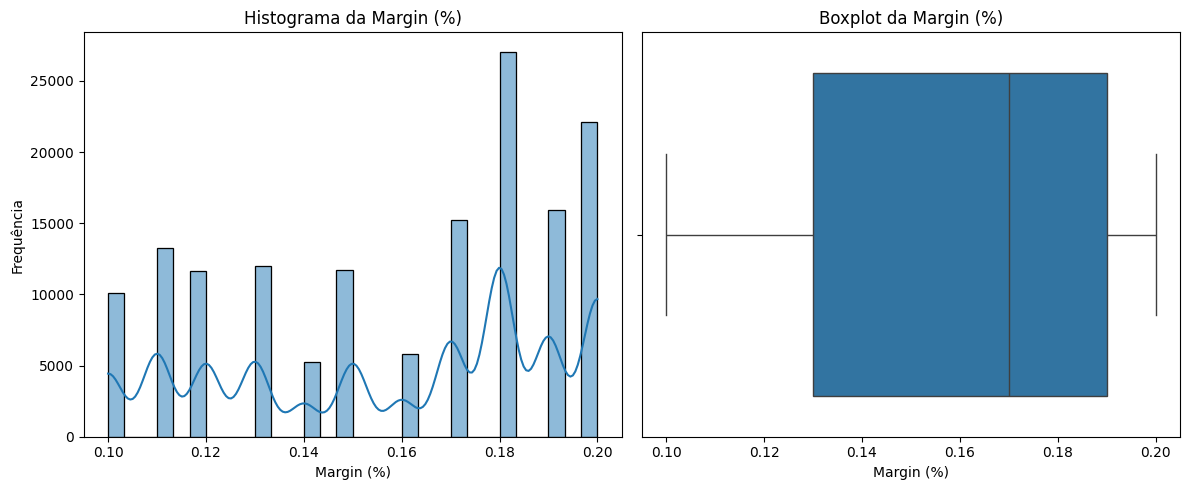

In [43]:
# Criar uma figura com 2 subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Histograma
sns.histplot(df['Margin (%)'].dropna(), bins=30, kde=True, ax=axes[0])
axes[0].set_title("Histograma da Margin (%)")
axes[0].set_xlabel("Margin (%)")
axes[0].set_ylabel("Frequência")

# Boxplot
sns.boxplot(x=df['Margin (%)'], ax=axes[1])
axes[1].set_title("Boxplot da Margin (%)")
axes[1].set_xlabel("Margin (%)")

plt.tight_layout()
plt.show()

### Profit (€)
Esta variável quantitativa contínua representa o lucro, em €, de cada produto.

Os seus valores variam entre 0.034 e 99.9.

Não contém valores ausentes e o seu formato é float.

In [44]:
#Visualizar dados
df['Profit (€)'].sample(10)

,Profit (€)
53863,0.1254
101387,0.2224
46891,0.1768
126273,0.1416
130575,0.236
64589,0.1173
92740,0.125
88716,0.0792
113163,0.0897
136188,0.099


In [45]:
#verificar missing values
df['Profit (€)'].isna().sum()

np.int64(0)

In [46]:
col_profit = "Profit (€)"

### perc_expiring_sku

Esta variável quantitativa contínua representa a proporçao do tempo de vida de um produto, quando a etiqueta foi colocada.

Os seus valores variam entre 0 e 2.

Existem 125 valores ausentes. Tratamento:

1 - Quando expiring_date = labelling_date, perc_expiring_sku deve ser 0 (se for missing)

2- Restantes valores ajustados à média

Identificados Valores acima de 1 - 25 Decisão: eliminar
Restantes 15 utilizado método flag para eliminação



In [47]:
#verificar missing values
df['perc_expiring_sku'].isna().sum()

np.int64(125)

In [48]:
#Tratamento missing values 1 - exp_date = lab_date
mask_same_date = (df["expiring_date"] == df["labelling_date"]) & (df["perc_expiring_sku"].isna())
df.loc[mask_same_date, "perc_expiring_sku"] = 0

In [49]:
#Tratamento missing values 2 - ajuste à média
df["perc_expiring_sku"] = df["perc_expiring_sku"].fillna(df["perc_expiring_sku"].mean())

In [50]:
# Identificar outliers de perc_expiring_sku > 1 - método flag
outliers = (df["perc_expiring_sku"] > 1).sum()
print(f"Valores > 1 identificados: {outliers}")

df.loc[df["perc_expiring_sku"] > 1, "flag"] = 1

# Verificação
print(f"Número de outliers marcados: {df['flag'].sum()}")

Valores > 1 identificados: 25
Número de outliers marcados: 40


### expiring_date

Variável é quantitativa contínua representa a data em que o artigo expira a sua validade, e apartir da qual não pode ser vendido. As datas de validade variam entre 2021-10-01 e 2021-11-20. Não contém valores ausentes. O seu formato é Datetime

In [51]:
#verificaçao de quais os símbolos usados para separar o dia, mês e ano.

#Garantir que os valores são strings
dates_as_str = df["expiring_date"].astype(str)

#Extrair apenas os caracteres que NÃO são dígitos
#re.findall("\D", x) devolve todos os caracteres não numéricos
non_numeric_chars = dates_as_str.apply(lambda x: re.findall(r"\D", x))

#Flatten (juntar tudo numa lista só)
all_non_numeric = [char for sublist in non_numeric_chars for char in sublist]

#Obter os símbolos únicos
unique_symbols = set(all_non_numeric)

print("Símbolos encontrados:", unique_symbols)

Símbolos encontrados: {'/', '-'}


In [52]:
# Correção do campo de data de "/" para "-" e mudança para formato Datetime

df["expiring_date"] = (
    df["expiring_date"]
    .str.replace("-", "/", regex=False)   # padroniza separador
    .pipe(pd.to_datetime, dayfirst=True, errors="coerce")  # converte
    .dt.date   # extrai apenas dia/mês/ano
)

In [53]:
print(df["expiring_date"].dtype)

object


In [54]:
print(df["expiring_date"].unique())

[datetime.date(2021, 10, 3) datetime.date(2021, 10, 2)
 datetime.date(2021, 10, 25) datetime.date(2021, 10, 26)
 datetime.date(2021, 10, 27) datetime.date(2021, 10, 15)
 datetime.date(2021, 10, 18) datetime.date(2021, 10, 28)
 datetime.date(2021, 10, 16) datetime.date(2021, 10, 23)
 datetime.date(2021, 10, 7) datetime.date(2021, 10, 30)
 datetime.date(2021, 10, 14) datetime.date(2021, 10, 21)
 datetime.date(2021, 10, 12) datetime.date(2021, 10, 9)
 datetime.date(2021, 10, 19) datetime.date(2021, 10, 5)
 datetime.date(2021, 10, 6) datetime.date(2021, 10, 11)
 datetime.date(2021, 10, 24) datetime.date(2021, 10, 13)
 datetime.date(2021, 10, 17) datetime.date(2021, 10, 10)
 datetime.date(2021, 10, 8) datetime.date(2021, 10, 22)
 datetime.date(2021, 11, 1) datetime.date(2021, 10, 20)
 datetime.date(2021, 10, 29) datetime.date(2021, 10, 31)
 datetime.date(2021, 10, 1) datetime.date(2021, 10, 4)
 datetime.date(2021, 11, 20) datetime.date(2021, 11, 2)
 datetime.date(2021, 11, 19) datetime.date

In [55]:
data_min = df["expiring_date"].min()
data_max = df["expiring_date"].max()
print(data_max)
print(data_min)

2021-11-20
2021-10-01


In [56]:
#verificar missing values
df['expiring_date'].isna().sum()

np.int64(0)

In [57]:
# Converter de texto para datetime64[ns], só com data (hora = 00:00:00)
df["expiring_date"] = (
    pd.to_datetime(df["expiring_date"], dayfirst=True, errors="coerce")
    .dt.normalize()
)


### labelling_date

Variável é quantitativa contínua, representa a data em que foi colocada a etiqueta no produto. As datas de etiquetagem variam entre 2021-10-01 e 2021-10-31. Não contém valores ausentes. O seu formato é Datetime

In [58]:
#verificaçao de quais os símbolos usados para separar o dia, mês e ano.

#Garantir que os valores são strings
dates_as_str = df["labelling_date"].astype(str)

#Extrair apenas os caracteres que NÃO são dígitos
#re.findall("\D", x) devolve todos os caracteres não numéricos
non_numeric_chars = dates_as_str.apply(lambda x: re.findall(r"\D", x))

#Flatten (juntar tudo numa lista só)
all_non_numeric = [char for sublist in non_numeric_chars for char in sublist]

#Obter os símbolos únicos
unique_symbols = set(all_non_numeric)

print("Símbolos encontrados:", unique_symbols)

Símbolos encontrados: {'-'}


In [59]:
print(df["labelling_date"].unique())

<DatetimeArray>
['2021-10-01 00:00:00', '2021-10-13 00:00:00', '2021-10-15 00:00:00',
 '2021-10-17 00:00:00', '2021-10-11 00:00:00', '2021-10-14 00:00:00',
 '2021-10-20 00:00:00', '2021-10-06 00:00:00', '2021-10-21 00:00:00',
 '2021-10-28 00:00:00', '2021-10-27 00:00:00', '2021-10-23 00:00:00',
 '2021-10-05 00:00:00', '2021-10-29 00:00:00', '2021-10-12 00:00:00',
 '2021-10-22 00:00:00', '2021-10-10 00:00:00', '2021-10-25 00:00:00',
 '2021-10-08 00:00:00', '2021-10-18 00:00:00', '2021-10-26 00:00:00',
 '2021-10-30 00:00:00', '2021-10-07 00:00:00', '2021-10-02 00:00:00',
 '2021-10-19 00:00:00', '2021-10-03 00:00:00', '2021-10-24 00:00:00',
 '2021-10-09 00:00:00', '2021-10-04 00:00:00', '2021-10-31 00:00:00',
 '2021-10-16 00:00:00']
Length: 31, dtype: datetime64[ns]


In [60]:
data_min = df["labelling_date"].min()
data_max = df["labelling_date"].max()
print(data_max)
print(data_min)

2021-10-31 00:00:00
2021-10-01 00:00:00


In [61]:
#verificar missing values
df['labelling_date'].isna().sum()

np.int64(0)

Filtrar casos sem utilidade

In [62]:
#Verificar sell date ou label date após expiring date

# Caso 1: labelling_date depois da expiring_date
cond1 = df["labelling_date"] > df["expiring_date"]
df.loc[cond1, "flag"] = 1
print(f"Caso 1 - labelling_date > expiring_date: {cond1.sum()} registos")

# Caso 2: sell_date depois da expiring_date (ignorando NaN)
cond2 = df["sell_date"].notna() & (df["sell_date"] > df["expiring_date"])
df.loc[cond2, "flag"] = 1
print(f"Caso 2 - sell_date > expiring_date: {cond2.sum()} registos")

# Caso 3: sell_date antes do labelling_date (ignorando NaN)
cond3 = df["sell_date"].notna() & (df["sell_date"] < df["labelling_date"])
df.loc[cond3, "flag"] = 1
print(f"Caso 3 - sell_date < labelling_date: {cond3.sum()} registos")

# Caso 4: expiring_date > máximo de sell_date e sold=0
max_sell_date = df["sell_date"].max()
cond4 = (df["expiring_date"] > max_sell_date) & (df["sold"] == 0)
df.loc[cond4, "flag"] = 1
print(f"Caso 4 - expiring_date > max(sell_date) & sold=0: {cond4.sum()} registos")

# Total marcados como incoerentes
print(f"TOTAL incoerentes (flag=1): {df['flag'].sum()}")


Caso 1 - labelling_date > expiring_date: 0 registos
Caso 2 - sell_date > expiring_date: 0 registos
Caso 3 - sell_date < labelling_date: 6 registos
Caso 4 - expiring_date > max(sell_date) & sold=0: 30 registos
TOTAL incoerentes (flag=1): 76


In [63]:
df[(df["expiring_date"] > df["sell_date"].max()) & (df["sold"] == 0)]

,idstore,sku,brand,oldpvp,weight (g),Payment_method,Margin (%),Profit (€),perc_expiring_sku,expiring_date,labelling_date,sell_date,sold,type,selling_square_ft,district,newpvp,discount,flag
7852,296,15,Marca 2,1.79,145.0,NaN,0.18,0.1602,0.125786,2021-11-20,2021-10-31,NaT,0,Small,379.0,Coimbra,0.89,0.50,1
10688,145,26,Marca 11,1.49,215.0,NaN,0.15,0.111,0.082645,2021-11-19,2021-10-30,NaT,0,Small,1352.0,Lisboa,0.74,0.50,1
10689,145,26,Marca 11,1.49,215.0,NaN,0.15,0.111,0.082645,2021-11-19,2021-10-30,NaT,0,Small,1352.0,Lisboa,0.74,0.50,1
10690,145,26,Marca 11,1.49,215.0,NaN,0.15,0.111,0.082645,2021-11-19,2021-10-30,NaT,0,Small,1352.0,Lisboa,0.74,0.50,1
10691,145,26,Marca 11,1.49,215.0,NaN,0.15,0.111,0.082645,2021-11-19,2021-10-30,NaT,0,Small,1352.0,Lisboa,0.74,0.50,1
10692,145,26,Marca 11,1.49,215.0,NaN,0.15,0.111,0.082645,2021-11-19,2021-10-30,NaT,0,Small,1352.0,Lisboa,0.74,0.50,1
32648,175,93,Marca 2,1.79,118.0,NaN,0.14,0.1246,0.125786,2021-11-20,2021-10-31,NaT,0,Medium,5576.0,Aveiro,0.89,0.50,1
32649,175,93,Marca 2,1.79,118.0,NaN,0.14,0.1246,0.125786,2021-11-20,2021-10-31,NaT,0,Medium,5576.0,Aveiro,0.89,0.50,1
32650,175,93,Marca 2,1.79,118.0,NaN,0.14,0.1246,0.125786,2021-11-20,2021-10-31,NaT,0,Medium,5576.0,Aveiro,0.89,0.50,1
32651,175,93,Marca 2,1.79,118.0,NaN,0.14,0.1246,0.125786,2021-11-20,2021-10-31,NaT,0,Medium,5576.0,Aveiro,0.89,0.50,1


### sell_date

Variável é quantitativa contínua representa a data em que o produto foi vendido.  

As datas de venda variam entre 2021-10-01 e 2021-11-18.
Contém 69543 valores ausentes que não foram tratados. Consideramos que correspondem a produtos que não foram vendidos.  

O seu formato é Datetime

In [64]:
#verificaçao de quais os símbolos usados para separar o dia, mês e ano.

#Garantir que os valores são strings
dates_as_str = df["sell_date"].astype(str)

#Extrair apenas os caracteres que NÃO são dígitos
#re.findall("\D", x) devolve todos os caracteres não numéricos
non_numeric_chars = dates_as_str.apply(lambda x: re.findall(r"\D", x))

#Flatten (juntar tudo numa lista só)
all_non_numeric = [char for sublist in non_numeric_chars for char in sublist]

#Obter os símbolos únicos
unique_symbols = set(all_non_numeric)

print("Símbolos encontrados:", unique_symbols)

Símbolos encontrados: {'a', 'N', '-', 'T'}


In [65]:
print(df["sell_date"].unique())

<DatetimeArray>
['2021-10-02 00:00:00',                 'NaT', '2021-10-03 00:00:00',
 '2021-10-14 00:00:00', '2021-10-15 00:00:00', '2021-10-16 00:00:00',
 '2021-10-17 00:00:00', '2021-10-18 00:00:00', '2021-10-19 00:00:00',
 '2021-10-20 00:00:00', '2021-10-22 00:00:00', '2021-10-21 00:00:00',
 '2021-10-23 00:00:00', '2021-10-12 00:00:00', '2021-10-24 00:00:00',
 '2021-10-25 00:00:00', '2021-10-26 00:00:00', '2021-10-08 00:00:00',
 '2021-10-10 00:00:00', '2021-10-11 00:00:00', '2021-10-28 00:00:00',
 '2021-10-27 00:00:00', '2021-10-06 00:00:00', '2021-10-29 00:00:00',
 '2021-10-13 00:00:00', '2021-10-09 00:00:00', '2021-10-07 00:00:00',
 '2021-10-30 00:00:00', '2021-10-04 00:00:00', '2021-10-05 00:00:00',
 '2021-10-31 00:00:00', '2021-11-01 00:00:00', '2021-10-01 00:00:00',
 '2021-11-02 00:00:00', '2021-11-06 00:00:00', '2021-11-03 00:00:00',
 '2021-11-04 00:00:00', '2021-11-14 00:00:00', '2021-11-12 00:00:00',
 '2021-11-10 00:00:00', '2021-11-05 00:00:00', '2021-11-17 00:00:00',
 '20

In [66]:
data_min = df["sell_date"].min()
data_max = df["sell_date"].max()
print(data_max)
print(data_min)

2021-11-18 00:00:00
2021-10-01 00:00:00


In [67]:
#verificar missing values
df['sell_date'].isna().sum()

np.int64(69543)

### sold (target)

Esta variável qualitativa categórica representa se um produto foi vendido (1) ou não foi vendido (0).

Contem 114 valores ausentes. Tratamento: preenchidos com base em informação de sell_date.

O seu formato é float.

In [68]:
#verificar missing values
df['sold'].isna().sum()

np.int64(114)

In [69]:
# Preencher missing values com 1, onde foi identificada informação de Sell_date ou, caso contrário, 0

df.loc[df["sold"].isna() & df["sell_date"].notna(), "sold"] = 1
df.loc[df["sold"].isna() & df["sell_date"].isna(), "sold"] = 0
print(df["sold"].unique())

<IntegerArray>
[1, 0]
Length: 2, dtype: Int64


In [70]:
#Verificar simbolos existentes

#Garantir que os valores são strings
dates_as_str = df["sold"].astype(str)

#Extrair apenas os caracteres que NÃO são dígitos
#re.findall("\D", x) devolve todos os caracteres não numéricos
non_numeric_chars = dates_as_str.apply(lambda x: re.findall(r"\D", x))

#Flatten (juntar tudo numa lista só)
all_non_numeric = [char for sublist in non_numeric_chars for char in sublist]

#Obter os símbolos únicos
unique_symbols = set(all_non_numeric)

print("Símbolos encontrados:", unique_symbols)

Símbolos encontrados: set()


...

#Standartização de variáveis decimais para 2 casas.

In [71]:
#standardizar a 2 casas decimais

df["discount"] = df["discount"].round(2)
df["newpvp"] = df["newpvp"].round(2)
df["oldpvp"] = df["oldpvp"].round(2)

df.head()

,idstore,sku,brand,oldpvp,weight (g),Payment_method,Margin (%),Profit (€),perc_expiring_sku,expiring_date,labelling_date,sell_date,sold,type,selling_square_ft,district,newpvp,discount,flag
0,1,1,Marca 1,4.22,260.0,Card,0.16,0.3376,0.01005,2021-10-03,2021-10-01,2021-10-02,1,Large,4762.0,Évora,2.11,0.5,0
1,1,1,Marca 1,3.96,260.0,NaN,0.16,0.3168,0.005025,2021-10-02,2021-10-01,NaT,0,Large,4762.0,Évora,1.98,0.5,0
2,1,1,Marca 1,4.74,260.0,Cash,0.16,0.3792,0.01005,2021-10-03,2021-10-01,2021-10-03,1,Large,4762.0,Évora,2.37,0.5,0
3,1,1,Marca 1,4.20,260.0,Card,0.16,0.336,0.01005,2021-10-03,2021-10-01,2021-10-02,1,Large,4762.0,Évora,2.10,0.5,0
4,1,1,Marca 1,4.62,260.0,Cash,0.16,0.3696,0.01005,2021-10-03,2021-10-01,2021-10-03,1,Large,4762.0,Évora,2.31,0.5,0


# Feature Engineering

## Normalizações

Transformação One-Hot Encoding para considerarmos variáveis nominais (sem ordem) para o modelo.

Transformação Label Encoding para considerarmos variáveis ordinais (com ordem natural) para o modelo.


In [72]:
# One-Hot Encoding para variáveis nominais (sem ordem)

if 'brand' in df.columns:
    # Criar dummies
    dummies = pd.get_dummies(df['brand'], prefix='d')

    # Adicionar ao dataframe
    df = pd.concat([df, dummies], axis=1)

    # Remover coluna original
    df = df.drop('brand', axis=1)

    print(f"Colunas dummy criadas: {list(dummies.columns)}")
    print("Coluna 'brand' original removida")

print(f"\nDataset após encoding: {df.shape}")
print(f"Colunas finais: {list(df.columns)}")

Colunas dummy criadas: ['d_Marca 1', 'd_Marca 10', 'd_Marca 11', 'd_Marca 12', 'd_Marca 13', 'd_Marca 14', 'd_Marca 15', 'd_Marca 16', 'd_Marca 17', 'd_Marca 18', 'd_Marca 19', 'd_Marca 2', 'd_Marca 20', 'd_Marca 21', 'd_Marca 22', 'd_Marca 23', 'd_Marca 24', 'd_Marca 25', 'd_Marca 26', 'd_Marca 27', 'd_Marca 28', 'd_Marca 29', 'd_Marca 3', 'd_Marca 30', 'd_Marca 31', 'd_Marca 32', 'd_Marca 33', 'd_Marca 34', 'd_Marca 35', 'd_Marca 36', 'd_Marca 37', 'd_Marca 38', 'd_Marca 39', 'd_Marca 4', 'd_Marca 40', 'd_Marca 41', 'd_Marca 42', 'd_Marca 5', 'd_Marca 6', 'd_Marca 7', 'd_Marca 8', 'd_Marca 9']
Coluna 'brand' original removida

Dataset após encoding: (150054, 60)
Colunas finais: ['idstore', 'sku', 'oldpvp', 'weight (g)', 'Payment_method', 'Margin (%)', 'Profit (€)', 'perc_expiring_sku', 'expiring_date', 'labelling_date', 'sell_date', 'sold', 'type', 'selling_square_ft', 'district', 'newpvp', 'discount', 'flag', 'd_Marca 1', 'd_Marca 10', 'd_Marca 11', 'd_Marca 12', 'd_Marca 13', 'd_Ma

In [73]:
# Label Encoding para variáveis ordinais (com ordem natural)

if 'type' in df.columns:
    # Mapeamento manual para preservar ordem
    cat_type = {'Small': 1, 'Medium': 2, 'Large': 3}
    df['type_encoded'] = df['type'].map(cat_type)
    print(f"Category Type: {cat_type}")

    contagem = df.value_counts(['type', 'type_encoded'])
    print(contagem)

   # Remover coluna original
    df = df.drop('type', axis=1)

Category Type: {'Small': 1, 'Medium': 2, 'Large': 3}
type    type_encoded
Medium  2               63236
Small   1               60599
Large   3               26219
Name: count, dtype: int64


##Tranformação de datas

Transformar datas em indicadores semanais e de fim-de-semana permite capturar padrões temporais relevantes para explicar o sucesso ou insucesso das vendas.

In [74]:
cols_dt = ['labelling_date','expiring_date']  # colunas de datas

# Guardar cópia antes da conversão
raw = df[cols_dt].copy()

#Contagens ANTES
nulls_before = raw.isna().sum().rename('nulls_before')
non_nulls_before = raw.notna().sum().rename('non_nulls_before')

#Converter
for c in cols_dt:
    df[c] = pd.to_datetime(df[c], errors='coerce')  # dayfirst=True se necessário

#Contagens DEPOIS
nulls_after = df[cols_dt].isna().sum().rename('nulls_after')
non_nulls_after = df[cols_dt].notna().sum().rename('non_nulls_after')

#Novos nulos criados pela conversão (existia valor e virou NaT)
new_nulls = ((raw.notna()) & (df[cols_dt].isna())).sum().rename('new_nulls_from_parse')

#linhas problemáticas para inspecionar
samples_problem = {}
for c in cols_dt:
    idx_bad = df.index[raw[c].notna() & df[c].isna()]
    samples_problem[c] = raw.loc[idx_bad, c].head(10)  # primeiros exemplos

#Relatório
audit = pd.concat([nulls_before, nulls_after, new_nulls, non_nulls_before, non_nulls_after], axis=1)
print(audit)
print("\nExemplos de valores que falharam parsing:")
for c, s in samples_problem.items():
    if len(s):
        print(f"\n{c}:")
        print(s.to_string(index=False))
    else:
        print(f"\n{c}: (sem falhas)")

                nulls_before  nulls_after  new_nulls_from_parse  \
labelling_date             0            0                     0   
expiring_date              0            0                     0   

                non_nulls_before  non_nulls_after  
labelling_date            150054           150054  
expiring_date             150054           150054  

Exemplos de valores que falharam parsing:

labelling_date: (sem falhas)

expiring_date: (sem falhas)


In [75]:
# Garantir datetime (seguro mesmo que já sejam)
for c in ["labelling_date", "expiring_date"]:
    df[c] = pd.to_datetime(df[c], errors="coerce")

# Função auxiliar: converte data → dia da semana (0–6) em float (NaT → NaN)
def dow_float(s):
    return s.dt.dayofweek.astype("float")

# labelling: sin/cos diretamente da data
w_lab = dow_float(df["labelling_date"])
df["labelling_dow_sin"] = np.sin(2 * np.pi * w_lab / 7)
df["labelling_dow_cos"] = np.cos(2 * np.pi * w_lab / 7)

# expiring: sin/cos diretamente da data
w_exp = dow_float(df["expiring_date"])
df["expiring_dow_sin"] = np.sin(2 * np.pi * w_exp / 7)
df["expiring_dow_cos"] = np.cos(2 * np.pi * w_exp / 7)

#Remoção de Outliers

In [76]:
#Retirar Outliers Flagged

df = df.drop(df[df["flag"] == 1].index)
df = df.drop(columns=["flag"])

# Removeção colunas

-Variáveis sem valor preditivo direto (Payment_method, Sell_date, labelqty)

- Datas originais foram transformadas em indicadores (*_weekday, is_weekend_*)."



In [77]:
#df = df.drop(columns=['idstore','Payment_method','expiring_date','labelling_date','sell_date'])
df = df.drop(columns=['Payment_method','expiring_date','labelling_date','sell_date'])

#Dataset Final

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 149978 entries, 0 to 150053
Data columns (total 59 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   idstore            149978 non-null  Int64  
 1   sku                149978 non-null  Int64  
 2   oldpvp             149978 non-null  float64
 3   weight (g)         149978 non-null  float64
 4   Margin (%)         149978 non-null  Float64
 5   Profit (€)         149978 non-null  Float64
 6   perc_expiring_sku  149978 non-null  Float64
 7   sold               149978 non-null  Int64  
 8   selling_square_ft  149978 non-null  Float64
 9   district           149978 non-null  string 
 10  newpvp             149978 non-null  float64
 11  discount           149978 non-null  float64
 12  d_Marca 1          149978 non-null  bool   
 13  d_Marca 10         149978 non-null  bool   
 14  d_Marca 11         149978 non-null  bool   
 15  d_Marca 12         149978 non-null  bool   
 16  d_Marca

In [79]:
df.head()

,idstore,sku,oldpvp,weight (g),Margin (%),Profit (€),perc_expiring_sku,sold,selling_square_ft,district,...,d_Marca 5,d_Marca 6,d_Marca 7,d_Marca 8,d_Marca 9,type_encoded,labelling_dow_sin,labelling_dow_cos,expiring_dow_sin,expiring_dow_cos
0,1,1,4.22,260.0,0.16,0.3376,0.01005,1,4762.0,Évora,...,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490
1,1,1,3.96,260.0,0.16,0.3168,0.005025,0,4762.0,Évora,...,False,False,False,False,False,3,-0.433884,-0.900969,-0.974928,-0.222521
2,1,1,4.74,260.0,0.16,0.3792,0.01005,1,4762.0,Évora,...,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490
3,1,1,4.20,260.0,0.16,0.336,0.01005,1,4762.0,Évora,...,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490
4,1,1,4.62,260.0,0.16,0.3696,0.01005,1,4762.0,Évora,...,False,False,False,False,False,3,-0.433884,-0.900969,-0.781831,0.623490


In [80]:
print(f"Número de linhas no df final: {df.shape[0]}")

Número de linhas no df final: 149978


# Criar csv

In [81]:
df.to_csv("Data_cleaned_final_antes_clusters.csv", index=False, encoding="utf-8-sig")

#Integração Dataframe Final com Clusters: SKU e Store

In [83]:
df_cluster = pd.read_csv("/content/Data_Store_Clustered.csv")

df_cluster = df_cluster[["idstore", "Cluster_KMeans"]].rename(
    columns={"Cluster_KMeans": "Store_cluster"}
)

df_cluster_store = pd.merge(
    df,
    df_cluster,
    on="idstore",
    how="left"
)

In [84]:
df_cluster_store = df_cluster_store.drop(columns=["idstore", "district"])

In [85]:
df_cluster_store.isna().sum().sum()

np.int64(4914)

In [86]:

df_sku_cluster = pd.read_csv("/content/Data_SKU_Clustered.csv")


df_sku_cluster = df_sku_cluster[["sku", "Cluster_KMeans"]].rename(
    columns={"Cluster_KMeans": "SKU_cluster"}
)

df_cluster_store_sku = pd.merge(
    df_cluster_store,
    df_sku_cluster,
    on="sku",
    how="left"
)

df_cluster_store_sku = df_cluster_store_sku.drop(columns=["sku"])

In [87]:
df_cluster_store_sku.isna().sum().sum()

np.int64(42050)

In [88]:
df_cluster_store_sku = pd.get_dummies(
    df_cluster_store_sku,
    columns=["Store_cluster", "SKU_cluster"],
    prefix=["StoreCluster", "SKUCluster"]
)


In [89]:
df_cluster_store_sku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149978 entries, 0 to 149977
Data columns (total 64 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   oldpvp             149978 non-null  float64
 1   weight (g)         149978 non-null  float64
 2   Margin (%)         149978 non-null  Float64
 3   Profit (€)         149978 non-null  Float64
 4   perc_expiring_sku  149978 non-null  Float64
 5   sold               149978 non-null  Int64  
 6   selling_square_ft  149978 non-null  Float64
 7   newpvp             149978 non-null  float64
 8   discount           149978 non-null  float64
 9   d_Marca 1          149978 non-null  bool   
 10  d_Marca 10         149978 non-null  bool   
 11  d_Marca 11         149978 non-null  bool   
 12  d_Marca 12         149978 non-null  bool   
 13  d_Marca 13         149978 non-null  bool   
 14  d_Marca 14         149978 non-null  bool   
 15  d_Marca 15         149978 non-null  bool   
 16  d_

In [90]:
df_cluster_store_sku.to_csv("Datacluster_store_sku.csv", index=False, encoding="utf-8-sig")